In [1]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
import pathlib
import pickle
import time
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
from IPython import display
from sklearn.preprocessing import LabelEncoder

import utils_img_rec as ut
import discriminator as dis
import generator as gen


2025-03-10 16:06:19.558310: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-10 16:06:19.599804: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741633579.631319    1208 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741633579.639456    1208 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-10 16:06:19.681986: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [3]:
data_path = "../data/mnist_train-pickle.pickle"
#data_path = "../data/mnist_train_1000-pickle.pickle"


out_path = "../data/output/mnist/"

data_path = pathlib.Path(data_path)
out_path = pathlib.Path(out_path)

IMG_SIZE = 28
channels = 1

BUFFER_SIZE = 56223
#BUFFER_SIZE = 10000

#BATCH_SIZE = 1000
BATCH_SIZE = 6247

EPOCHS = 3
noise_dim = 100
num_examples_to_generate = 16

checkpoint_dir = '../models/training_checkpoints'

In [4]:
import tensorflow as tf
tf.config.optimizer.set_jit(False)


if tf.test.gpu_device_name():
    pass
else:
    print('Nenhuma GPU encontrada')
tf.__version__

I0000 00:00:1741633582.040397    1208 gpu_device.cc:2022] Created device /device:GPU:0 with 5592 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6


'2.18.0'

In [5]:
pickle_in = open(data_path,"rb")
data_train = pickle.load(pickle_in)

In [6]:
CATEGORIES = ut.get_classes(data_train)
CATEGORIES.sort()
try:
    CATEGORIES.remove('.ipynb_checkpoints')
except:
    pass

print(CATEGORIES)
num_of_classes = len(CATEGORIES)
print(num_of_classes)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
10


In [7]:
train_X, train_y = ut.prep_data(data=data_train, CATEGORIES=CATEGORIES, IMG_SIZE=IMG_SIZE, num_of_channels=channels)
print('Entradas de treino - {} - ({}x{})'.format( train_X.shape[0], train_X.shape[1], train_X.shape[2] ))
print(train_X.shape)

Entradas de treino - 56223 - (28x28)
(56223, 28, 28, 1)


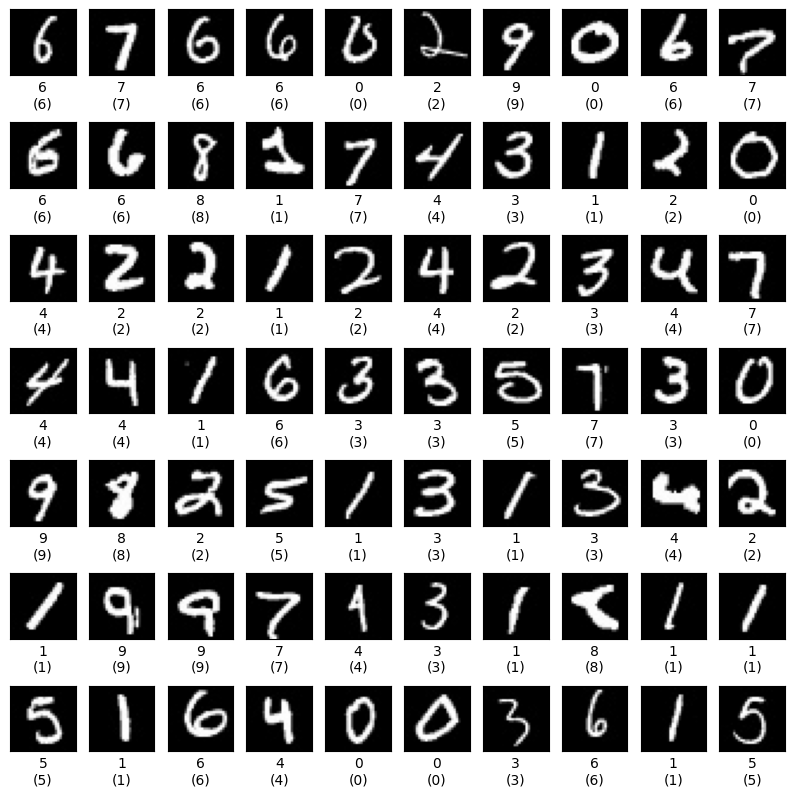

In [8]:
ut.plot_images(data_train)

In [9]:
train_images = np.array(train_X)
train_images = train_images.reshape(-1, IMG_SIZE, IMG_SIZE, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_y)) \
                               .shuffle(BUFFER_SIZE) \
                               .batch(BATCH_SIZE)

I0000 00:00:1741633584.230489    1208 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5592 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6


/home/erick/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


W0000 00:00:1741633584.927998    1291 gpu_backend_lib.cc:579] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation or runtime failures, if the program we try to run uses routines from libdevice.
Searched for CUDA in the following directories:
  ./cuda_sdk_lib
  ipykernel_launcher.runfiles/cuda_nvcc
  ipykern/cuda_nvcc
  
  /usr/local/cuda
  /home/erick/miniconda3/lib/python3.12/site-packages/tensorflow/python/platform/../../../nvidia/cuda_nvcc
  /home/erick/miniconda3/lib/python3.12/site-packages/tensorflow/python/platform/../../../../nvidia/cuda_nvcc
  /home/erick/miniconda3/lib/python3.12/site-packages/tensorflow/python/platform/../../cuda
  .
You can choose the search directory by setting xla_gpu_cuda_data_dir in HloModule's DebugOptions.  For most apps, setting the environment variable XLA_FLAGS=--xla_gpu_cuda_data_dir=/path/to/cuda will work.
I0000 00:00:1741633585.563428    1208 cuda_dnn.cc:529] Loaded cuDNN version 90800


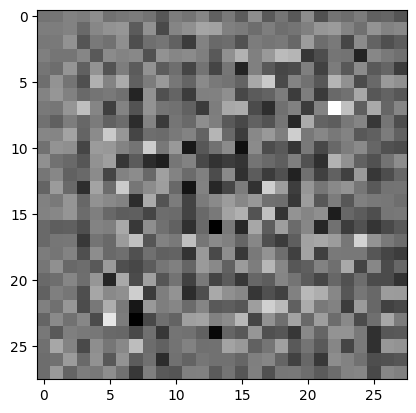

In [10]:
generator = gen.make_generator_model(noise_dim + num_of_classes)

extra_values = tf.constant([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])  # Tensor de shape (1,2)
noise = tf.concat([tf.random.normal([1, noise_dim]), extra_values], axis=1)  # Agora shape será (1, 102)

generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [11]:
discriminator = dis.make_discriminator_model(num_of_labels=num_of_classes)
decision = discriminator([generated_image,extra_values])
print (decision)

W0000 00:00:1741633586.368110    1208 gpu_backend_lib.cc:617] libdevice is required by this HLO module but was not found at ./libdevice.10.bc
error: libdevice not found at ./libdevice.10.bc
2025-03-10 16:06:26.369008: E tensorflow/compiler/mlir/tools/kernel_gen/tf_framework_c_interface.cc:228] INTERNAL: Generating device code failed.
2025-03-10 16:06:26.369903: W tensorflow/core/framework/op_kernel.cc:1829] UNKNOWN: JIT compilation failed.
2025-03-10 16:06:26.369945: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: UNKNOWN: JIT compilation failed.


UnknownError: Exception encountered when calling BatchNormalization.call().

[1m{{function_node __wrapped__Rsqrt_device_/job:localhost/replica:0/task:0/device:GPU:0}} JIT compilation failed. [Op:Rsqrt] name: [0m

Arguments received by BatchNormalization.call():
  • inputs=tf.Tensor(shape=(1, 32), dtype=float32)
  • training=False
  • mask=None

In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
seed, _ = ut.create_seed(num_examples_to_generate=num_examples_to_generate, noise_dim=noise_dim, num_classes=num_of_classes)
seed.shape

TensorShape([16, 110])

In [ ]:
@tf.function
def train_step(images, labels):

    real_batch_size = tf.shape(images)[0]

    noise = tf.random.normal([real_batch_size, noise_dim])
    labels = tf.cast(labels, tf.float32)  # Converte os labels para float32
    noise = tf.concat([noise, labels], axis=1)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        # Passa os dois inputs para o discriminador: imagem e label
        real_output = discriminator([images, labels], training=True)
        fake_output = discriminator([generated_images, labels], training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch, label_batch in dataset:  # Agora pegamos rótulos junto com imagens
            train_step(image_batch, label_batch)  # Passamos diretamente para train_step

        # Exibir imagens geradas ao longo do treinamento
        display.clear_output(wait=True)
        ut.generate_and_save_images(generator, epoch + 1, seed, out_path)

        # Salvar modelo a cada 15 épocas
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        print(f'Time for epoch {epoch + 1} is {time.time()-start:.2f} sec')

    # Gerar imagens após a última época
    display.clear_output(wait=True)
    ut.generate_and_save_images(generator, epochs, seed, out_path)
    print(f'Total training time {time.time()-start:.2f} sec after {epoch+1} epochs')

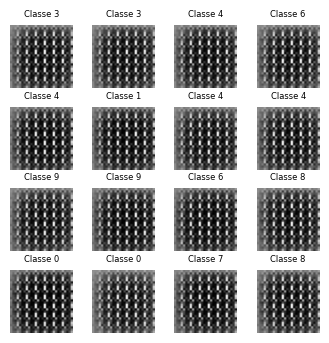

Total training time 38.00 sec after 3 epochs


In [ ]:
train(train_dataset, EPOCHS)

Restore the latest checkpoint.

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

ValueError: Received incompatible tensor with shape (32, 16) when attempting to restore variable with shape (10, 8) and name dense_4/kernel:0.

In [ ]:
ut.display_image(EPOCHS, out_path)

In [ ]:
anim_file = 'dcgan.gif'
fps = 30

with imageio.get_writer(anim_file, mode='I', fps=fps) as writer:
    # Obtenha a lista de arquivos de imagem
    filenames = sorted(out_path.glob('image*.png'))
    for filename in filenames:
        # Leia a imagem
        image = imageio.imread(filename)
        # Adicione a imagem ao GIF
        writer.append_data(image)
    # Adicione o último quadro para criar uma animação contínua
    image = imageio.imread(filenames[-1])
    writer.append_data(image)

/tmp/ipykernel_33311/2563346831.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
/tmp/ipykernel_33311/2563346831.py:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filenames[-1])


In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)